In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pickle
import pandas as pd
import numpy as np

In [0]:
import os
os.chdir('/content/drive/My Drive/3001 Time Series Project')

In [0]:
filename = 'data_LDS.pickle'
with open(filename, 'rb') as f:
  train, val, test = pickle.load(f)

# train = pd.read_csv('lds_train_concate.csv', sep = "|")  
# val = pd.read_csv('lds_val_concate.csv', sep = "|") 
# test = pd.read_csv('lds_test_concate.csv', sep = "|")   

In [10]:
# train.drop(['Unnamed: 0'], axis = 1, inplace = True)
# val.drop(['Unnamed: 0'], axis = 1, inplace = True)
# test.drop(['Unnamed: 0'], axis = 1, inplace = True)

KeyError: ignored

In [23]:
train.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BaseExcess',
       'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
       'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total',
       'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets',
       'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 'patient_id'],
      dtype='object')

In [0]:
X_feature = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BaseExcess',
       'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
       'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total',
       'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets',
       'Age', 'Gender', 'HospAdmTime', 'ICULOS']
y_feature = 'SepsisLabel'

In [0]:
X_train = train[X_feature]
y_train = train[y_feature]
X_val = val[X_feature]
y_val = val[y_feature]
X_test = test[X_feature]
y_test = test[y_feature]

In [16]:
# Reference
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=1211), max_features=37)
embeded_rf_selector.fit(X_train, y_train)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
display(embeded_rf_feature)

15 selected features


['HR',
 'O2Sat',
 'Temp',
 'SBP',
 'MAP',
 'DBP',
 'Resp',
 'BaseExcess',
 'BUN',
 'Creatinine',
 'WBC',
 'Platelets',
 'Age',
 'HospAdmTime',
 'ICULOS']

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


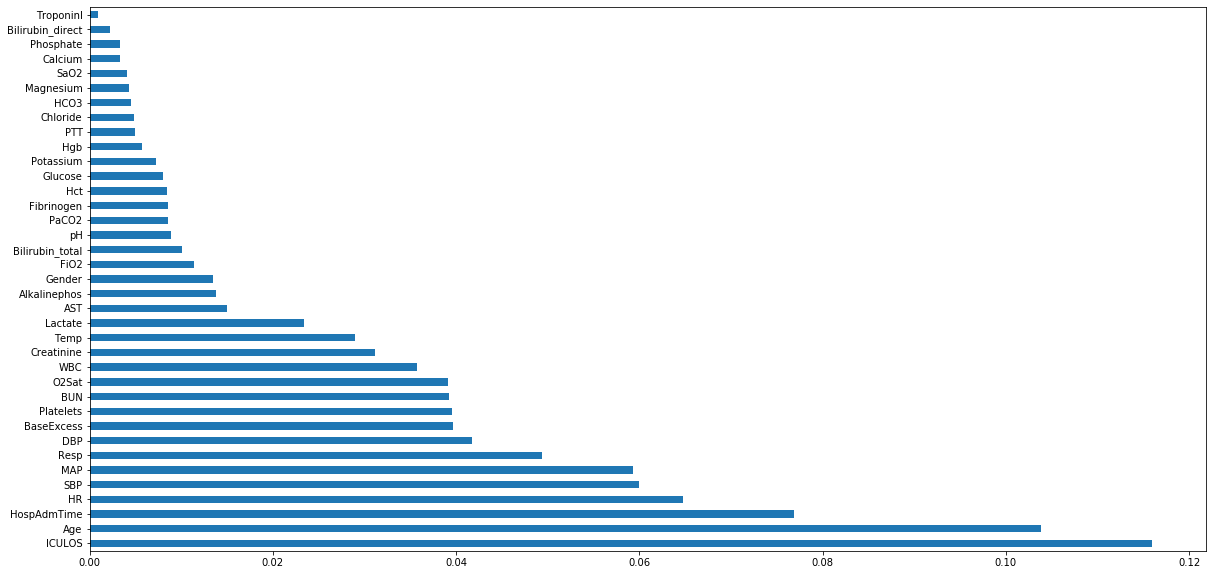

In [17]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
plt.figure(figsize=(20,10))

model = RandomForestClassifier(random_state=1211)
model.fit(X_train,y_train)
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(37).plot(kind='barh')
plt.show()

In [18]:
feat = feat_importances.sort_values(ascending=False).index
rf_feature = feat[:15]
rf_feature

Index(['ICULOS', 'Age', 'HospAdmTime', 'HR', 'SBP', 'MAP', 'Resp', 'DBP',
       'BaseExcess', 'Platelets', 'BUN', 'O2Sat', 'WBC', 'Creatinine', 'Temp'],
      dtype='object')

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[50,100,150], 'max_depth':[None, 5, 10,15]}
rf = GridSearchCV(RandomForestClassifier(random_state=1211, oob_score=True, class_weight='balanced_subsample'), parameters, scoring='f1')
rf.fit(X_train,y_train)
print(rf.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 15, 'n_estimators': 100}


W/o feature selection

In [28]:
from sklearn.metrics import classification_report, auc, precision_recall_curve, roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

best = RandomForestClassifier(random_state=1211, oob_score=True, max_depth=15, n_estimators=100, class_weight='balanced_subsample')
best.fit(X_train,y_train)

y_pred_best = best.predict(X_val)
y_pred_proba_best = best.predict_proba(X_val)[::,1]
precision_best, recall_best, thresholds_best = precision_recall_curve(y_val, y_pred_proba_best)
auc_best = auc(recall_best, precision_best)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_best)
auroc = auc(fpr, tpr)

print(classification_report(y_val, y_pred_best))
print('F1 score:', f1_score(y_val,y_pred_best))
print('Precision:', precision_score(y_val,y_pred_best))
print('Recall:', recall_score(y_val,y_pred_best))
print('AUPRC:', auc_best)
print('AUC:', auroc)
print('Accuracy:', accuracy_score(y_val,y_pred_best))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    116372
           1       0.16      0.09      0.11      2501

    accuracy                           0.97    118873
   macro avg       0.57      0.54      0.55    118873
weighted avg       0.96      0.97      0.97    118873

F1 score: 0.11449016100178891
Precision: 0.15864022662889518
Recall: 0.08956417433026789
AUPRC: 0.07050167548716715
AUC: 0.674129214020919
Accuracy: 0.9708512446055875


Text(0.5, 1.0, 'Precision-Recall Curve For LDS')

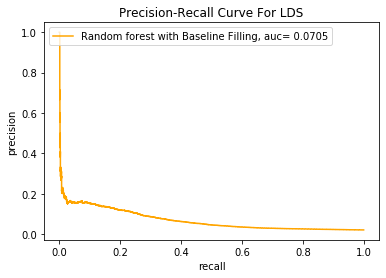

In [29]:
from matplotlib import pyplot as plt

plt.plot(recall_best,precision_best, color = 'orange', label="Random forest with Baseline Filling, auc= %.4f" %auc_best)
plt.legend(loc=2)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall Curve For LDS')

In [30]:
! pip install plot-metric

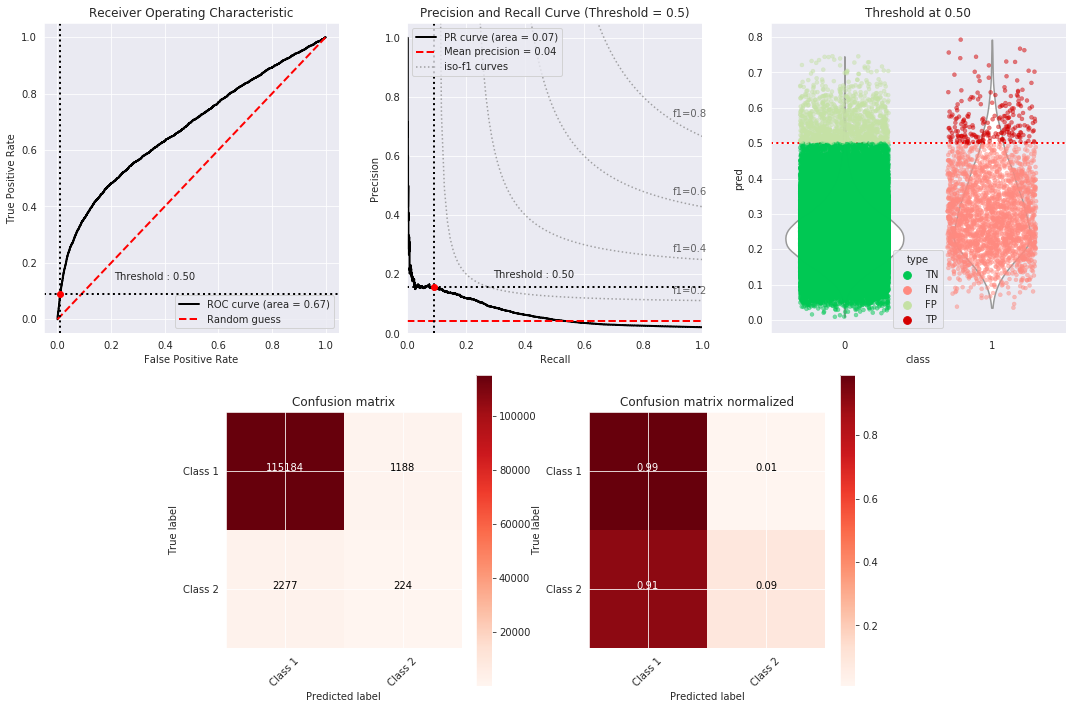

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

     Class 1       0.98      0.99      0.99    116372
     Class 2       0.16      0.09      0.11      2501

    accuracy                           0.97    118873
   macro avg       0.57      0.54      0.55    118873
weighted avg       0.96      0.97      0.97    118873



In [31]:
from plot_metric.functions import BinaryClassification
bc = BinaryClassification(y_val,y_pred_proba_best, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()
plt.subplot2grid((2,6), (0,2), colspan=2)
bc.plot_precision_recall_curve()
plt.subplot2grid((2,6), (0,4), colspan=2)
bc.plot_class_distribution()
plt.subplot2grid((2,6), (1,1), colspan=2)
bc.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc.plot_confusion_matrix(normalize=True)
plt.show()
bc.print_report()

W/ feature selection

In [0]:
X_train_fs = train[embeded_rf_feature]
X_val_fs = val[embeded_rf_feature]

In [33]:
best = RandomForestClassifier(random_state=1211, oob_score=True, max_depth=20, n_estimators=100, class_weight='balanced_subsample')
best.fit(X_train_fs,y_train)

y_pred_best = best.predict(X_val_fs)
y_pred_proba_best = best.predict_proba(X_val_fs)[::,1]
precision_best, recall_best, thresholds_best = precision_recall_curve(y_val, y_pred_proba_best)
auc_best = auc(recall_best, precision_best)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_best)
auroc = auc(fpr, tpr)

print(classification_report(y_val, y_pred_best))
print('F1 score:', f1_score(y_val,y_pred_best))
print('Precision:', precision_score(y_val,y_pred_best))
print('Recall:', recall_score(y_val,y_pred_best))
print('AUPRC:', auc_best)
print('AUC:', auroc)
print('Accuracy:', accuracy_score(y_val,y_pred_best))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    116372
           1       0.16      0.02      0.03      2501

    accuracy                           0.98    118873
   macro avg       0.57      0.51      0.51    118873
weighted avg       0.96      0.98      0.97    118873

F1 score: 0.02977487291212782
Precision: 0.16205533596837945
Recall: 0.01639344262295082
AUPRC: 0.07251800197403074
AUC: 0.7034250782552273
Accuracy: 0.9775222296063867


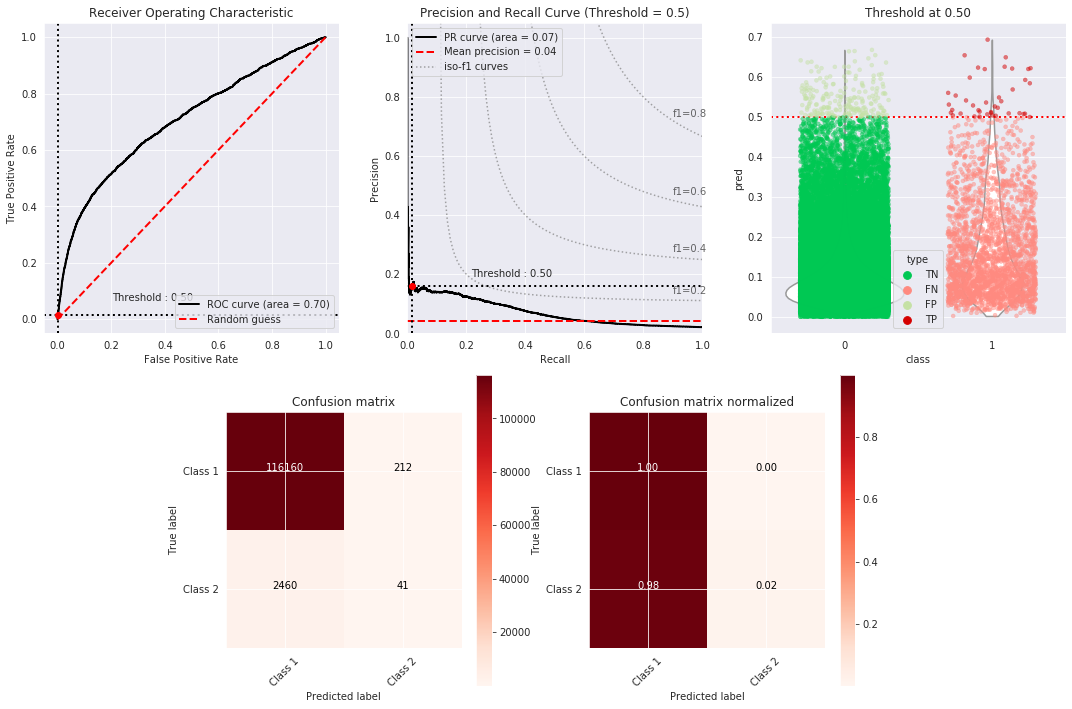

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

     Class 1       0.98      1.00      0.99    116372
     Class 2       0.16      0.02      0.03      2501

    accuracy                           0.98    118873
   macro avg       0.57      0.51      0.51    118873
weighted avg       0.96      0.98      0.97    118873



In [34]:
from plot_metric.functions import BinaryClassification
bc = BinaryClassification(y_val,y_pred_proba_best, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()
plt.subplot2grid((2,6), (0,2), colspan=2)
bc.plot_precision_recall_curve()
plt.subplot2grid((2,6), (0,4), colspan=2)
bc.plot_class_distribution()
plt.subplot2grid((2,6), (1,1), colspan=2)
bc.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc.plot_confusion_matrix(normalize=True)
plt.show()
bc.print_report()

# Performance on test

In [35]:
best = RandomForestClassifier(random_state=1211, oob_score=True, max_depth=10, n_estimators=100, class_weight='balanced_subsample')
best.fit(X_train,y_train)

y_pred_best = best.predict(X_test)
y_pred_proba_best = best.predict_proba(X_test)[::,1]
precision_best, recall_best, thresholds_best = precision_recall_curve(y_test, y_pred_proba_best)
auc_best = auc(recall_best, precision_best)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
auroc = auc(fpr, tpr)

print(classification_report(y_test, y_pred_best))
print('F1 score:', f1_score(y_test,y_pred_best))
print('Precision:', precision_score(y_test,y_pred_best))
print('Recall:', recall_score(y_test,y_pred_best))
print('AUPRC:', auc_best)
print('AUC:', auroc)
print('Accuracy:', accuracy_score(y_test,y_pred_best))

              precision    recall  f1-score   support

           0       0.99      0.75      0.85    115737
           1       0.05      0.54      0.08      2502

    accuracy                           0.75    118239
   macro avg       0.52      0.65      0.47    118239
weighted avg       0.97      0.75      0.84    118239

F1 score: 0.08330525864445193
Precision: 0.04510929052373213
Recall: 0.5435651478816946
AUPRC: 0.07269438683270643
AUC: 0.6950619412364731
Accuracy: 0.7468601730393525


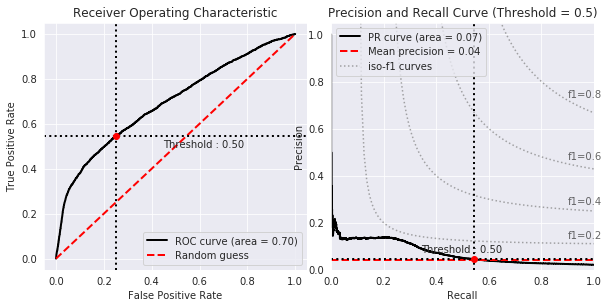

In [36]:
bc = BinaryClassification(y_test,y_pred_proba_best, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()
plt.subplot2grid((2,6), (0,2), colspan=2)
bc.plot_precision_recall_curve()
# plt.subplot2grid((2,6), (0,4), colspan=2)
# bc.plot_class_distribution()
# plt.subplot2grid((2,6), (1,1), colspan=2)
# bc.plot_confusion_matrix()
# plt.subplot2grid((2,6), (1,3), colspan=2)
# bc.plot_confusion_matrix(normalize=True)
plt.show()
# bc.print_report()